In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report's Experiments</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group #35</center>

## Support Vector Classifier

In [10]:
def filter_svc_cv_results(cv_results):
    
    if 'param_kernel' in cv_results.columns:
        
        cv_results = cv_results[['param_C', 'param_kernel', 'mean_fit_time',
                                 'mean_train_accuracy', 'mean_test_accuracy',
                                 'mean_train_nr_support_vectors', 'mean_test_nr_support_vectors']]
        cv_results.rename(columns={'param_kernel': 'kernel'}, inplace=True)
    
    elif 'param_optimizer' in cv_results.columns:
        
        cv_results = cv_results[['param_C', 'param_optimizer', 'mean_fit_time',
                                 'mean_train_accuracy', 'mean_test_accuracy',
                                 'mean_train_nr_support_vectors', 'mean_test_nr_support_vectors']]
        cv_results.rename(columns={'param_optimizer': 'optimizer'}, inplace=True)
    
    else:
        
        cv_results = cv_results[['param_C', 'mean_fit_time',
                                 'mean_train_accuracy', 'mean_test_accuracy',
                                 'mean_train_nr_support_vectors', 'mean_test_nr_support_vectors']]
    
    cv_results.sort_values(['param_C'], inplace=True)
    cv_results.rename(columns={'param_C': 'C',
                               'mean_fit_time': 'fit_time',
                               'mean_train_accuracy': 'train_accuracy',
                               'mean_test_accuracy': 'test_accuracy',
                               'mean_train_nr_support_vectors': 'nr_train_sv',
                               'mean_test_nr_support_vectors': 'nr_test_sv'}, inplace=True)
    
    cv_results['nr_train_sv'] = cv_results['nr_train_sv'].round().astype(int)
    cv_results['nr_test_sv'] = cv_results['nr_test_sv'].round().astype(int)

    return cv_results

### Hinge loss

#### Primal formulation

In [5]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge, squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [7]:
def primal_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y),
            'nr_support_vectors': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 3 folds for each of 3 candidates, totalling 9 fits


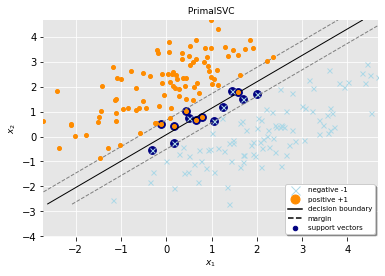

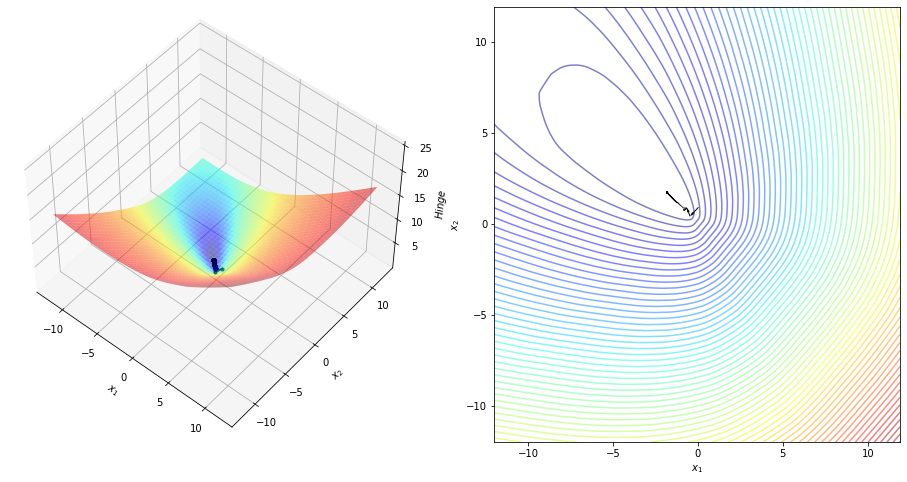

In [8]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate=0.5),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_svm_hyperplane(grid.best_estimator_, X, y)
plt.savefig('./tex/img/svc_hyperplane.png')
plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_hinge_loss.png')

In [9]:
custom_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_primal_svc_hinge_cv_results.to_latex('./tex/experiments/custom_primal_svc_hinge.tex', index=False)
custom_primal_svc_hinge_cv_results.style.hide_index()

C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,0.590823,0.982475,0.980024,11,5
10,0.551638,0.982494,0.980024,7,4
100,0.462036,0.982494,0.980024,6,4


In [10]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SkLinearSVC(loss='hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [11]:
sklearn_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
sklearn_primal_svc_hinge_cv_results.to_latex('./tex/experiments/sklearn_primal_svc_hinge.tex', index=False)
sklearn_primal_svc_hinge_cv_results.style.hide_index()

C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,0.001263,0.990012,0.989974,8,5
10,0.001231,0.992500,0.995025,4,3
100,0.001234,0.995006,0.980024,4,1


#### Dual formulations

In [4]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, poly, gaussian
from optiml.ml.utils import generate_linearly_separable_overlap_data

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC as SklSVC
from sklearn.model_selection import GridSearchCV

In [7]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y),
            'nr_support_vectors': len(svc.support_)}

In [43]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [44]:
linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_dual_svc_cv_results.style.hide_index()

C,optimizer,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,smo,0.045861,0.980006,0.980024,13,13
1,cvxopt,0.014506,0.980006,0.980024,14,14
10,smo,0.255484,0.982512,0.980024,8,8
10,cvxopt,0.017180,0.980006,0.980024,9,9
100,smo,0.403307,0.982512,0.980024,7,7
100,cvxopt,0.023317,0.982512,0.980024,13,13


In [45]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(SklSVC(),
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [46]:
sklinear_dual_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
sklinear_dual_cv_results.insert(1, 'optimizer', 'sklearn')
sklinear_dual_cv_results.style.hide_index()

C,optimizer,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,sklearn,0.001665,0.977537,0.970074,27,27
10,sklearn,0.001544,0.977518,0.965099,16,16
100,sklearn,0.001475,0.982512,0.965099,13,13


In [47]:
overall_linear_dual_svc_cv_results = linear_dual_svc_cv_results.append(sklinear_dual_cv_results, ignore_index=True)
overall_linear_dual_svc_cv_results.sort_values(['C', 'optimizer'], inplace=True)
overall_linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', index=False)
overall_linear_dual_svc_cv_results.style.hide_index()

C,optimizer,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,cvxopt,0.014506,0.980006,0.980024,14,14
1,sklearn,0.001665,0.977537,0.970074,27,27
1,smo,0.045861,0.980006,0.980024,13,13
10,cvxopt,0.017180,0.980006,0.980024,9,9
10,sklearn,0.001544,0.977518,0.965099,16,16
10,smo,0.255484,0.982512,0.980024,8,8
100,cvxopt,0.023317,0.982512,0.980024,13,13
100,sklearn,0.001475,0.982512,0.965099,13,13
100,smo,0.403307,0.982512,0.980024,7,7


In [50]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=True),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [51]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', index=False)
linear_lagrangian_dual_svc_cv_results.style.hide_index()

C,optimizer,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
1,smo,0.071004,0.974993,0.969998,14,14
1,cvxopt,0.015356,0.974993,0.969998,14,14
10,smo,0.107962,0.974975,0.965023,10,10
10,cvxopt,0.015125,0.974975,0.965023,10,10
100,smo,1.209578,0.974975,0.965023,10,10
100,cvxopt,0.021266,0.974975,0.965023,11,11


In [ ]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.5, fit_intercept=False),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

### Squared Hinge loss

#### Primal formulation

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


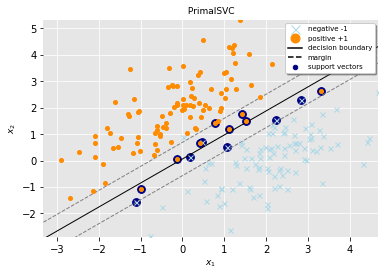

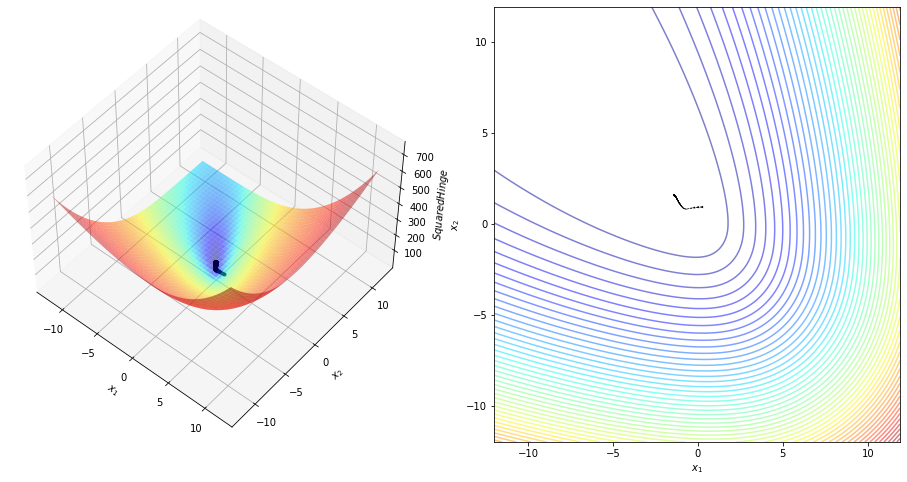

In [145]:
X, y = generate_linearly_separable_overlap_data()

grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.1),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

plot_trajectory_optimization(grid.best_estimator_.loss, grid.best_estimator_.optimizer, 
                             x_min=-12, x_max=12, y_min=-12, y_max=12)
plt.savefig('./tex/img/svc_squared_hinge_loss.png')

In [146]:
filtered_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
filtered_cv_results.to_latex('./tex/experiments/custom_primal_svc_squared_hinge.tex', index=False)
filtered_cv_results.style.hide_index()

size,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
100,1,0.666572,0.978750,0.975000,11,3
100,10,0.606052,0.977500,0.975000,8,2
100,100,0.533989,0.976250,0.965000,4,1
100,1000,0.460636,0.978750,0.975000,1,0
1000,1,0.802890,0.977750,0.978000,94,25
1000,10,0.847619,0.977500,0.977500,79,20
1000,100,0.816650,0.976750,0.976500,29,8
1000,1000,0.613090,0.978125,0.978000,3,0
10000,1,3.355230,0.977800,0.977850,946,236
10000,10,3.376311,0.977737,0.977700,817,205


In [149]:
X, y = generate_linearly_separable_overlap_data(size=size)

grid = GridSearchCV(SkLinearSVC(loss='squared_hinge'),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=3,  # 3 fold cross validation
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt best accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [150]:
filtered_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
filtered_cv_results.to_latex('./tex/experiments/sklearn_primal_svc_squared_hinge.tex', index=False)
filtered_cv_results.style.hide_index()

size,C,fit_time,train_accuracy,test_accuracy,nr_train_sv,nr_test_sv
100,1,0.001275,0.975000,0.975000,28,7
100,10,0.001922,0.975000,0.975000,24,5
100,100,0.001788,0.973750,0.975000,24,4
100,1000,0.001708,0.948750,0.960000,24,5
1000,1,0.009750,0.978625,0.978000,223,54
1000,10,0.016280,0.978375,0.977500,219,54
1000,100,0.019560,0.974250,0.973500,237,58
1000,1000,0.017598,0.939875,0.936500,328,85
10000,1,0.406137,0.976913,0.976800,2116,525
10000,10,0.594236,0.976913,0.976950,2113,526


## Support Vector Regression

In [10]:
def filter_svr_cv_results(cv_results):
    
    if 'param_kernel' in cv_results.columns:
        
        cv_results = cv_results[['param_C', 'param_kernel', 'mean_fit_time',
                                 'mean_train_r2', 'mean_test_r2',
                                 'mean_train_nr_support_vectors', 'mean_test_nr_support_vectors']]
        cv_results.rename(columns={'param_kernel': 'kernel'}, inplace=True)
    
    elif 'param_optimizer' in cv_results.columns:
        
        cv_results = cv_results[['param_C', 'param_optimizer', 'mean_fit_time',
                                 'mean_train_r2', 'mean_test_r2',
                                 'mean_train_nr_support_vectors', 'mean_test_nr_support_vectors']]
        cv_results.rename(columns={'param_optimizer': 'optimizer'}, inplace=True)
    
    else:
        
        cv_results = cv_results[['param_C', 'mean_fit_time',
                                 'mean_train_r2', 'mean_test_r2',
                                 'mean_train_nr_support_vectors', 'mean_test_nr_support_vectors']]
    
    cv_results.sort_values(['param_C'], inplace=True)
    cv_results.rename(columns={'param_C': 'C',
                               'mean_fit_time': 'fit_time',
                               'mean_train_r2': 'train_r2',
                               'mean_test_r2': 'test_r2',
                               'mean_train_nr_support_vectors': 'nr_train_sv',
                               'mean_test_nr_support_vectors': 'nr_test_sv'}, inplace=True)
    
    cv_results['nr_train_sv'] = cv_results['nr_train_sv'].round().astype(int)
    cv_results['nr_test_sv'] = cv_results['nr_test_sv'].round().astype(int)

    return cv_results

### Epsilon-insensitive loss

#### Primal formulation

In [4]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive, squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.datasets import make_regression

In [ ]:
def primal_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y),
            'nr_support_vectors': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

#### Dual formulations

In [ ]:
def dual_r2_scorer(svr, X, y):
    return {'r2': svr.score(X, y),
            'nr_support_vectors': len(svr.support_)}

### Squared Epsilon-insensitive loss

#### Primal formulation

epoch	iter	 cost	
   0	   0	 5.0554e+02	val_loss:  4.0542e+02	r2:  0.0186	val_r2:  0.0202
 200	 200	 3.0884e+02	val_loss:  2.6962e+02	r2:  0.6507	val_r2:  0.6410
 400	 400	 2.4122e+02	val_loss:  2.3162e+02	r2:  0.7963	val_r2:  0.7856
 600	 600	 1.9700e+02	val_loss:  2.0925e+02	r2:  0.8696	val_r2:  0.8589
 800	 800	 1.6619e+02	val_loss:  1.9435e+02	r2:  0.9114	val_r2:  0.9009
1000	1000	 1.4632e+02	val_loss:  1.8556e+02	r2:  0.9364	val_r2:  0.9263
1200	1200	 1.3295e+02	val_loss:  1.8464e+02	r2:  0.9519	val_r2:  0.9422
1400	1400	 1.2292e+02	val_loss:  1.8450e+02	r2:  0.9616	val_r2:  0.9523
1600	1600	 1.1609e+02	val_loss:  1.8471e+02	r2:  0.9678	val_r2:  0.9587
1800	1800	 1.1205e+02	val_loss:  1.8510e+02	r2:  0.9717	val_r2:  0.9629
2000	2000	 1.1023e+02	val_loss:  1.8549e+02	r2:  0.9743	val_r2:  0.9657
2200	2200	 1.0881e+02	val_loss:  1.8585e+02	r2:  0.9759	val_r2:  0.9675
2400	2400	 1.0822e+02	val_loss:  1.8617e+02	r2:  0.9769	val_r2:  0.9687
2600	2600	 1.0784e+02	val_loss:  1.8644e+02	r2

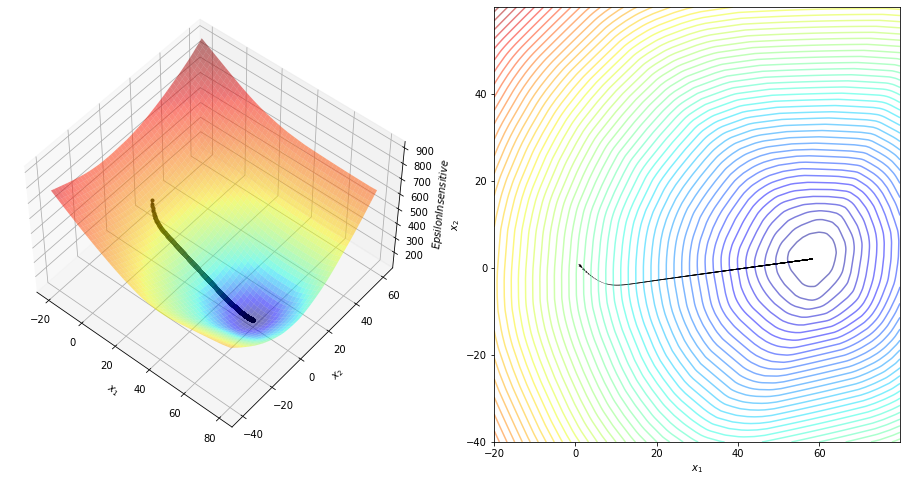

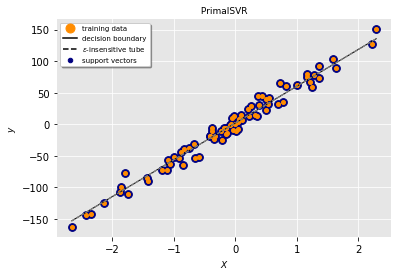

svr r2 score is 0.977062497664484
svr found 75 support vectors from 75 examples
svr w is [58.22121652]
svr b is 2.03514638565529

CPU times: user 1.94 ms, sys: 124 µs, total: 2.07 ms
Wall time: 1.62 ms


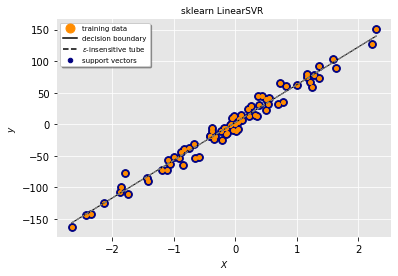

sklearn svr r2 score is 0.9764953146596664
sklearn svr found 74 support vectors from 75 examples
sklearn svr w is [59.71438415]
sklearn svr b is [2.91299935]


In [5]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = PrimalSVR(loss=epsilon_insensitive, epsilon=0.1, C=10, optimizer=AdaGrad, 
                learning_rate=1., max_iter=3000, validation_split=0.2, verbose=200)
%time svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, x_min=-20, x_max=80, y_min=-40, y_max=60)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SkLinearSVR(loss='epsilon_insensitive', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

iter	feval	 cost		 gnorm
   0	   1	 3.5616e+04	 1.2014e+03	ls:  1	it:  1	astar:  4.7324e-02
   1	   3	 1.5359e+03	 1.5819e+02	ls:  1	it:  1	astar:  5.1479e-02
   2	   5	 8.9685e+02	 2.2657e+01	ls:  1	it:  1	astar:  4.7324e-02
   3	   7	 8.8499e+02	 2.9833e+00	ls:  1	it:  1	astar:  5.1479e-02
   4	   9	 8.8477e+02	 4.2729e-01	ls:  1	it:  2	astar:  4.7324e-02
   5	  11	 8.8477e+02	 5.6261e-02	ls:  1	it:  8	astar:  5.1479e-02
   6	  19	 8.8477e+02	 8.0582e-03	ls:  1	it:  7	astar:  4.7324e-02
   7	  26	 8.8477e+02	 1.0610e-03	ls:  1	it:  6	astar:  5.1479e-02
   8	  32	 8.8477e+02	 1.5197e-04	ls:  1	it:  2	astar:  4.7324e-02
   9	  34	 8.8477e+02	 2.0009e-05	ls:  1	it:  4	astar:  5.1574e-02
  10	  38	 8.8477e+02	 2.8714e-06	ls:  1	it:  2	astar:  4.7165e-02
  11	  40	 8.8477e+02	 3.7372e-07

CPU times: user 12.1 ms, sys: 4.33 ms, total: 16.4 ms
Wall time: 12.8 ms


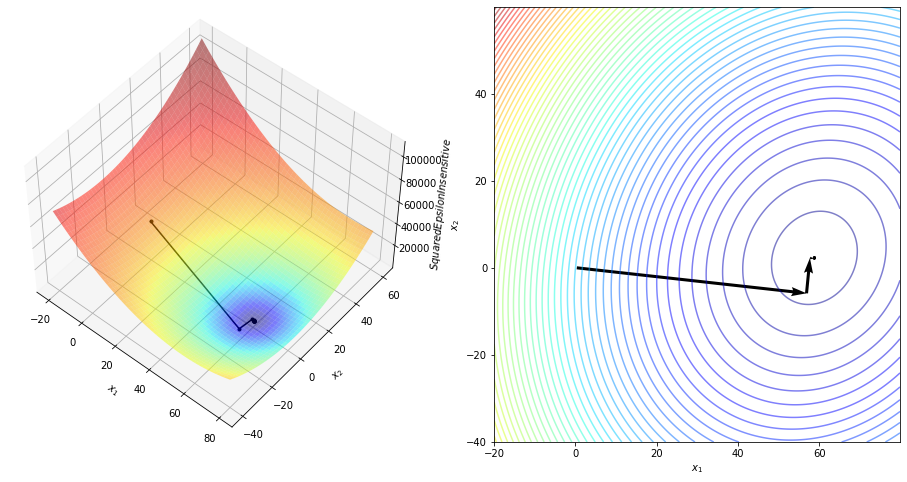

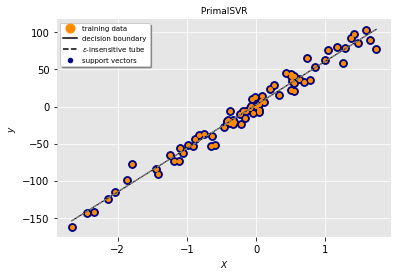

svr r2 score is 0.9815988018645927
svr found 75 support vectors from 75 examples
svr w is [58.83256051]
svr b is 2.303905473543353

CPU times: user 3.37 ms, sys: 0 ns, total: 3.37 ms
Wall time: 2.77 ms


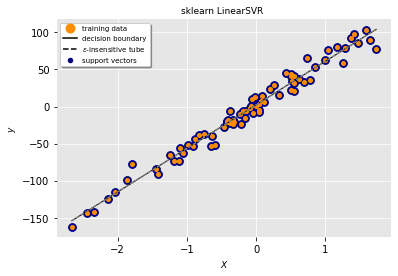

sklearn svr r2 score is 0.981583884871758
sklearn svr found 75 support vectors from 75 examples
sklearn svr w is [58.81896316]
sklearn svr b is [2.30068004]


In [31]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = PrimalSVR(loss=squared_epsilon_insensitive, epsilon=0.1, C=10, 
                optimizer=SteepestGradientDescent, verbose=True)
%time svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, x_min=-20, x_max=80, y_min=-40, y_max=60)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SkLinearSVR(loss='squared_epsilon_insensitive', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
support_ = np.argwhere(np.abs(y_train - svr.predict(X_train)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [32]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from sklearn.svm import SVR as SklSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

iter	 cost
   0	-6.2037e+03
   3	-6.8519e+03
   6	-6.9873e+03
   9	-7.0608e+03
  12	-7.0624e+03
  15	-7.0641e+03
  18	-7.0657e+03
  21	-7.0673e+03
  24	-7.0682e+03
  27	-7.0691e+03
  30	-7.0700e+03
  33	-7.0709e+03
  36	-7.0716e+03
  39	-7.0722e+03

CPU times: user 822 ms, sys: 354 ms, total: 1.18 s
Wall time: 191 ms


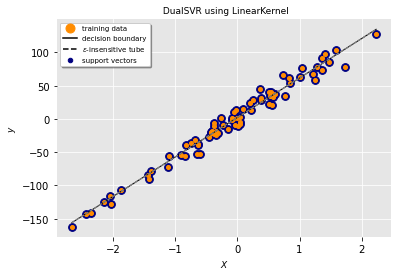

svr r2 score is 0.974828140190886
svr found 75 support vectors from 75 examples
svr w is [59.47669884]
svr b is 2.122650013728763

     pcost       dcost       gap    pres   dres
 0: -7.9071e+03 -2.2785e+04  5e+04  1e+00  5e-16
 1: -5.3712e+03 -1.2744e+04  7e+03  6e-14  4e-16
 2: -6.5430e+03 -7.4715e+03  9e+02  1e-13  3e-16
 3: -6.9645e+03 -7.1609e+03  2e+02  1e-13  3e-16
 4: -7.0471e+03 -7.0939e+03  5e+01  8e-14  3e-16
 5: -7.0698e+03 -7.0747e+03  5e+00  5e-14  3e-16
 6: -7.0722e+03 -7.0723e+03  1e-01  9e-14  3e-16
 7: -7.0723e+03 -7.0723e+03  1e-03  5e-14  3e-16
Optimal solution found.

CPU times: user 229 ms, sys: 93.9 ms, total: 323 ms
Wall time: 50.1 ms


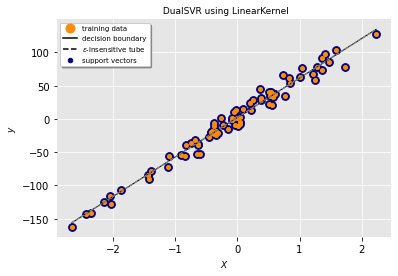

cvxopt svr r2 score is 0.9748172307112926
cvxopt svr found 75 support vectors from 75 examples
cvxopt svr w is [59.47670217]
cvxopt svr b is 2.0905802493036263

CPU times: user 1.59 ms, sys: 134 µs, total: 1.72 ms
Wall time: 1.07 ms


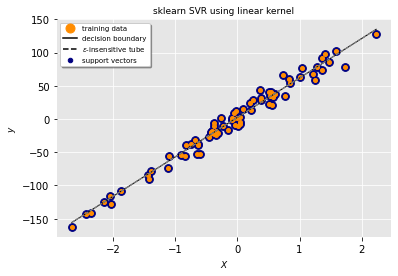

sklearn svr r2 score is 0.974902108680764
sklearn svr found 75 support vectors from 75 examples
sklearn svr w is [[59.4766987]]
sklearn svr b is [2.40525739]


In [36]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer=SMORegression, verbose=3)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer='cvxopt', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr w is {svr.coef_}')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SklSVR(kernel='linear', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [7]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.7603e+03	pcost: -1.3182e+03	gap:  3.3540e-01	rnorm: 8.8855e-11
 100	 100	-1.7226e+03	pcost: -1.3182e+03	gap:  3.0679e-01	rnorm: 4.7584e-11
 200	 200	-1.7060e+03	pcost: -1.3182e+03	gap:  2.9419e-01	rnorm: 3.7688e-11
 300	 300	-1.6933e+03	pcost: -1.3182e+03	gap:  2.8457e-01	rnorm: 3.7996e-11
 400	 400	-1.6827e+03	pcost: -1.3182e+03	gap:  2.7650e-01	rnorm: 6.2396e-11
 500	 500	-1.6733e+03	pcost: -1.3182e+03	gap:  2.6941e-01	rnorm: 4.4999e-11
 600	 600	-1.6649e+03	pcost: -1.3182e+03	gap:  2.6303e-01	rnorm: 4.6768e-11
 700	 700	-1.6572e+03	pcost: -1.3182e+03	gap:  2.5717e-01	rnorm: 3.9275e-11
 800	 800	-1.6500e+03	pcost: -1.3182e+03	gap:  2.5174e-01	rnorm: 4.9341e-11
 900	 900	-1.6433e+03	pcost: -1.3182e+03	gap:  2.4665e-01	rnorm: 4.4386e-11

CPU times: user 4.01 s, sys: 4.43 s, total: 8.44 s
Wall time: 2.48 s


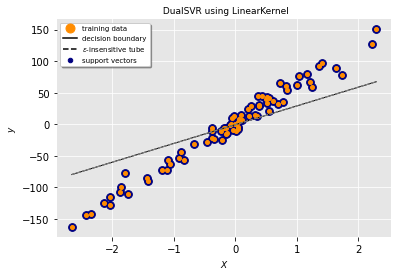

svr r2 score is 0.733784331965381
svr found 75 support vectors from 75 examples
svr w is [29.66739397]
svr b is -0.5829721199584127


In [10]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer=AdaGrad, fit_intercept=True, verbose=100)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

epoch	iter	 cost	
   0	   0	-1.7959e+03	pcost: -1.3445e+03	gap:  3.3579e-01	rnorm: 2.6295e-11
 100	 100	-1.7502e+03	pcost: -1.3445e+03	gap:  3.0180e-01	rnorm: 2.5326e-11
 200	 200	-1.7301e+03	pcost: -1.3445e+03	gap:  2.8687e-01	rnorm: 2.3170e-11
 300	 300	-1.7148e+03	pcost: -1.3445e+03	gap:  2.7548e-01	rnorm: 2.1730e-11
 400	 400	-1.7020e+03	pcost: -1.3445e+03	gap:  2.6594e-01	rnorm: 2.7497e-11
 500	 500	-1.6907e+03	pcost: -1.3445e+03	gap:  2.5756e-01	rnorm: 1.9001e-11
 600	 600	-1.6806e+03	pcost: -1.3445e+03	gap:  2.5002e-01	rnorm: 3.3364e-11
 700	 700	-1.6713e+03	pcost: -1.3445e+03	gap:  2.4312e-01	rnorm: 3.0961e-11
 800	 800	-1.6627e+03	pcost: -1.3445e+03	gap:  2.3671e-01	rnorm: 1.8451e-11
 900	 900	-1.6546e+03	pcost: -1.3445e+03	gap:  2.3072e-01	rnorm: 2.9731e-11

CPU times: user 7.1 s, sys: 9.47 s, total: 16.6 s
Wall time: 5.11 s


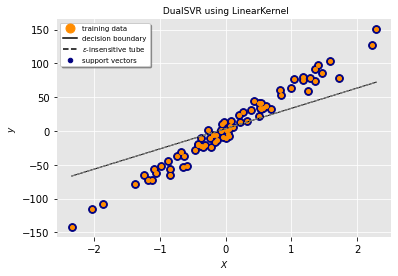

svr r2 score is 0.678831212681787
svr found 75 support vectors from 75 examples
svr w is [29.95083546]
svr b is 3.5753115444611407


In [11]:
X, y = make_regression(n_samples=100, n_features=1, noise=10., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=linear, epsilon=0.1, C=10, optimizer=AdaGrad, fit_intercept=False, verbose=100)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

### Nonlinear Support Vector Machines

#### Support Vector Classifier

In [40]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SklSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-3.8915e-02
   5	-7.4285e-02
  10	-8.0784e-02
  15	-8.0797e-02
  20	-8.0804e-02
  25	-8.0865e-02
  30	-8.0879e-02
  35	-8.0889e-02
  40	-8.0894e-02
  45	-8.0896e-02
  50	-8.0897e-02
  55	-8.0897e-02

CPU times: user 1.37 s, sys: 1.09 s, total: 2.46 s
Wall time: 479 ms


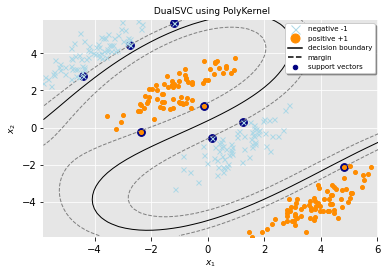

svc accuracy score is 0.99
svc found 8 support vectors from 300 examples
svc b is -0.39090409395469894

     pcost       dcost       gap    pres   dres
 0: -3.4122e+02 -3.3938e+04  1e+05  1e+00  9e-11
 1: -1.7325e+02 -1.4503e+04  3e+04  2e-01  6e-11
 2: -4.1036e+01 -3.3642e+03  6e+03  5e-02  3e-11
 3: -8.2065e+00 -1.0808e+03  2e+03  1e-02  1e-11
 4:  5.0085e+00 -6.9186e+01  1e+02  7e-04  3e-12
 5:  3.4128e+00 -2.8036e+01  4e+01  2e-04  9e-13
 6:  1.1145e+00 -5.1984e+00  7e+00  2e-05  1e-13
 7:  1.5933e-01 -3.5861e-01  5e-01  2e-07  8e-15
 8:  1.2324e-02 -1.2559e-01  1e-01  5e-08  5e-15
 9: -2.5892e-02 -1.2117e-01  1e-01  2e-08  3e-15
10: -5.4092e-02 -1.1421e-01  6e-02  6e-09  3e-15
11: -5.8025e-02 -1.1183e-01  5e-02  4e-09  3e-15
12: -7.7191e-02 -8.5496e-02  8e-03  2e-10  4e-15
13: -7.7789e-02 -8.5026e-02  7e-03  1e-10  3e-15
14: -8.0372e-02 -8.1558e-02  1e-03  1e-11  3e-15
15: -8.0878e-02 -8.0920e-02  4e-05  2e-13  4e-15
16: -8.0897e-02 -8.0897e-02  5e-07  3e-15  4e-15
17: -8.0897e-02

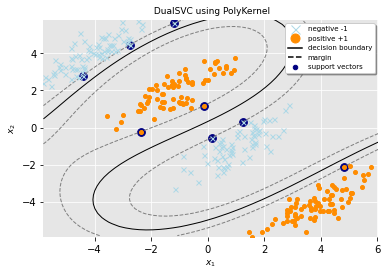

cvxopt svc accuracy score is 0.98
cvxopt svc found 8 support vectors from 300 examples
cvxopt svc b is -0.3467706042660512

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.79 ms


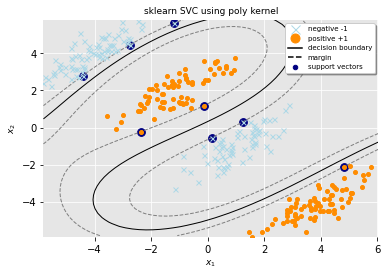

sklearn svc accuracy score is 0.98
sklearn svc found 8 support vectors from 300 examples
sklearn svc b is [-0.34684554]


In [41]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), C=10, optimizer=SMOClassifier, verbose=5)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), C=10, optimizer='cvxopt', verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'cvxopt svc accuracy score is {svc.score(X_test, y_test)}')
print(f'cvxopt svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SklSVC(kernel='poly', degree=3, coef0=3, gamma='auto', C=1)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

In [12]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-7.7467e-03	pcost:  1.4083e-02	gap:  2.1829e-02	rnorm: 2.4283e+03
   1	   1	-6.5521e-03	pcost:  1.0468e-02	gap:  1.7020e-02	rnorm: 2.2341e+03
   2	   2	-5.5418e-03	pcost:  7.5272e-03	gap:  1.3069e-02	rnorm: 2.0537e+03
   3	   3	-4.6874e-03	pcost:  5.1467e-03	gap:  9.8340e-03	rnorm: 1.8885e+03
   4	   4	-3.9647e-03	pcost:  3.2312e-03	gap:  7.1959e-03	rnorm: 1.7375e+03
   5	   5	-3.3535e-03	pcost:  1.7014e-03	gap:  5.0549e-03	rnorm: 1.5974e+03
   6	   6	-2.8366e-03	pcost:  4.9042e-04	gap:  3.3270e-03	rnorm: 1.4693e+03
   7	   7	-2.3993e-03	pcost: -4.5764e-04	gap:  1.9417e-03	rnorm: 1.3514e+03
   8	   8	-2.0295e-03	pcost: -1.1894e-03	gap:  8.4014e-04	rnorm: 1.2428e+03
   9	   9	-1.7168e-03	pcost: -1.7439e-03	gap: -2.7149e-05	rnorm: 1.1431e+03

CPU times: user 434 ms, sys: 577 ms, total: 1.01 s
Wall time: 262 ms


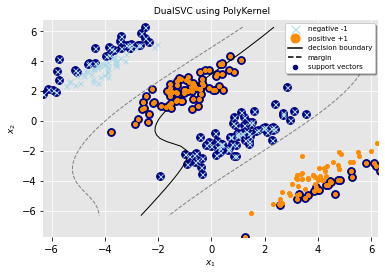

svc accuracy score is 0.58
svc found 205 support vectors from 300 examples
svc b is 0.15780880747543763


In [13]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), C=10, 
              optimizer=AdaGrad, fit_intercept=True, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

epoch	iter	 cost	
   0	   0	-8.2066e-03	pcost:  1.6771e-02	gap:  2.4978e-02	rnorm: 1.0374e+04
  50	  50	-7.6895e-03	pcost:  1.4401e-02	gap:  2.2090e-02	rnorm: 1.4751e+03
 100	 100	-3.1365e-02	pcost:  4.4729e-03	gap:  3.5838e-02	rnorm: 6.3444e+03
 150	 150	-2.1285e-02	pcost:  4.4729e-03	gap:  2.5758e-02	rnorm: 1.7980e+03
 200	 200	-1.4642e-02	pcost:  4.4729e-03	gap:  1.9114e-02	rnorm: 1.0235e+03
 250	 250	-1.1098e-02	pcost:  4.4729e-03	gap:  1.5571e-02	rnorm: 3.9224e+02
 300	 300	-9.3854e-03	pcost:  4.4729e-03	gap:  1.3858e-02	rnorm: 4.7143e+02
 350	 350	-1.0073e-02	pcost:  4.4729e-03	gap:  1.4546e-02	rnorm: 3.2462e+03
 400	 400	-8.2830e-03	pcost:  4.4729e-03	gap:  1.2756e-02	rnorm: 8.7870e+02
 450	 450	-7.9434e-03	pcost:  4.4729e-03	gap:  1.2416e-02	rnorm: 7.7797e+02
 500	 500	-2.8105e-02	pcost:  4.3686e-03	gap:  3.2474e-02	rnorm: 1.6962e+04
 550	 550	-6.2011e-03	pcost:  3.6487e-03	gap:  9.8498e-03	rnorm: 6.7454e+02
 600	 600	-5.8404e-03	pcost:  3.6487e-03	gap:  9.4890e-03	rnorm: 8.783

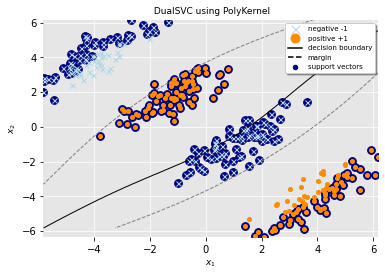

svc accuracy score is 0.51
svc found 243 support vectors from 300 examples
svc b is -0.12142988578041303


In [15]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), C=10, 
              optimizer=AdaGrad, fit_intercept=False, verbose=50)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

#### Support Vector Regression

In [46]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SklSVR
from sklearn.model_selection import train_test_split

CPU times: user 28min 51s, sys: 179 ms, total: 28min 51s
Wall time: 28min 51s


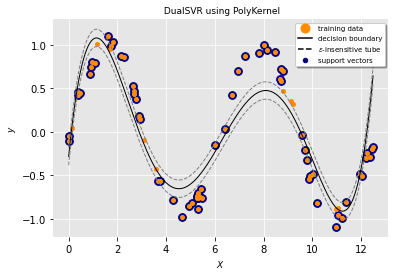

svr r2 score is 0.8866781000272429
svr found 65 support vectors from 75 examples
svr b is -0.2984941354199902

     pcost       dcost       gap    pres   dres
 0: -2.6829e+00 -1.9707e+02  2e+02  3e-17  4e-10
 1: -5.4548e+00 -2.5355e+01  2e+01  1e-16  4e-10
 2: -1.1473e+01 -1.6126e+01  5e+00  2e-16  4e-10
 3: -1.2899e+01 -1.4323e+01  1e+00  2e-16  4e-10
 4: -1.3431e+01 -1.3735e+01  3e-01  2e-16  3e-10
 5: -1.3518e+01 -1.3623e+01  1e-01  2e-16  3e-10
 6: -1.3560e+01 -1.3574e+01  1e-02  2e-16  4e-10
 7: -1.3566e+01 -1.3567e+01  7e-04  1e-16  4e-10
 8: -1.3567e+01 -1.3567e+01  7e-06  2e-16  4e-10
Optimal solution found.

CPU times: user 68.9 ms, sys: 52 ms, total: 121 ms
Wall time: 19.2 ms


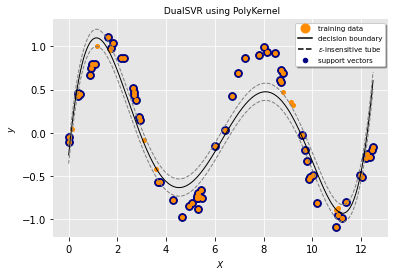

cvxopt svr r2 score is 0.8831486000403188
cvxopt svr found 65 support vectors from 75 examples
cvxopt svr b is 0.025836426934174643

CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.02 s


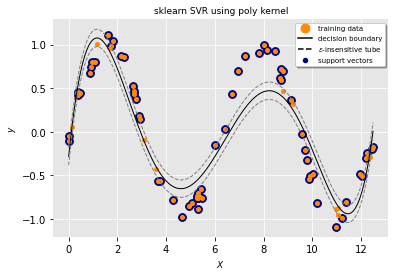

sklearn svr r2 score is 0.8817037899796948
sklearn svr found 64 support vectors from 75 examples
sklearn svr b is [-0.29943022]


In [7]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), 
              epsilon=0.1, C=10, optimizer=SMORegression, verbose=False)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), 
              epsilon=0.1, C=10, optimizer='cvxopt', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SklSVR(kernel='poly', degree=5, coef0=4, gamma='scale', epsilon=0.1, C=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')

In [16]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-4.2129e+00	pcost: -2.4079e+00	gap:  7.4963e-01	itn:  11	rnorm: 2.7479e+00
   1	   1	-3.5003e+00	pcost: -2.4079e+00	gap:  4.5367e-01	itn:  11	rnorm: 2.4907e+00
   2	   2	-3.0560e+00	pcost: -2.4079e+00	gap:  2.6919e-01	itn:  11	rnorm: 2.4030e+00
   3	   3	-2.7258e+00	pcost: -2.4079e+00	gap:  1.3202e-01	itn:  11	rnorm: 2.3910e+00
   4	   4	-2.4617e+00	pcost: -2.4079e+00	gap:  2.2355e-02	itn:  11	rnorm: 2.4217e+00
   5	   5	-2.2419e+00	pcost: -2.4079e+00	gap: -6.8935e-02	itn:  11	rnorm: 2.4783e+00

CPU times: user 147 ms, sys: 163 ms, total: 310 ms
Wall time: 65.2 ms


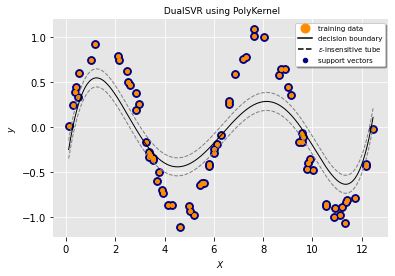

svr r2 score is 0.5517886427293541
svr found 75 support vectors from 75 examples
svr b is -0.06413651711427736


In [17]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), epsilon=0.1, C=10, optimizer=AdaGrad, 
              fit_intercept=True, lagrangian_solver='lsqr', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

epoch	iter	 cost	
   0	   0	-3.5406e+00	pcost: -2.0304e+00	gap:  7.4378e-01	itn:  11	rnorm: 2.6296e+00
   1	   1	-2.9495e+00	pcost: -2.0304e+00	gap:  4.5262e-01	itn:  11	rnorm: 2.3732e+00
   2	   2	-2.5799e+00	pcost: -2.0304e+00	gap:  2.7060e-01	itn:  11	rnorm: 2.2799e+00
   3	   3	-2.3046e+00	pcost: -2.0304e+00	gap:  1.3503e-01	itn:  11	rnorm: 2.2607e+00
   4	   4	-2.0842e+00	pcost: -2.0304e+00	gap:  2.6464e-02	itn:  11	rnorm: 2.2842e+00
   5	   5	-1.9005e+00	pcost: -2.0304e+00	gap: -6.4023e-02	itn:  11	rnorm: 2.3341e+00

CPU times: user 106 ms, sys: 131 ms, total: 237 ms
Wall time: 60.1 ms


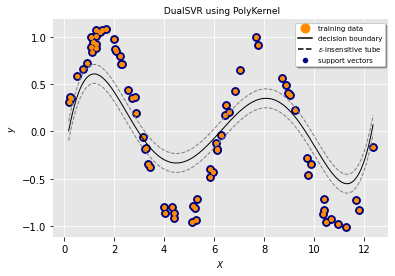

svr r2 score is 0.6645106505032261
svr found 75 support vectors from 75 examples
svr b is 0.03577968024109529


In [18]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=PolyKernel(degree=5, coef0=4, gamma='scale'), epsilon=0.1, C=10, optimizer=AdaGrad, 
              fit_intercept=False, lagrangian_solver='lsqr', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

#### Support Vector Classifier

In [50]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SklSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-8.9667e+00
   2	-1.0346e+01
   4	-1.0408e+01
   6	-1.0412e+01
   8	-1.0412e+01
  10	-1.0417e+01
  12	-1.0417e+01

CPU times: user 1.95 s, sys: 1.42 s, total: 3.38 s
Wall time: 749 ms


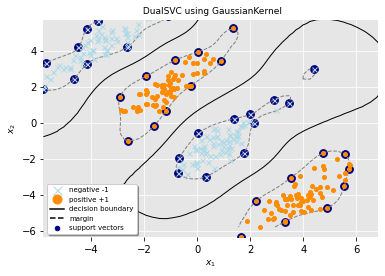

svc accuracy score is 1.0
svc found 41 support vectors from 300 examples
svc b is 0.016687303831847404

     pcost       dcost       gap    pres   dres
 0:  4.7378e+02 -5.5695e+03  1e+04  2e-01  2e-15
 1:  2.6328e+02 -6.3289e+02  1e+03  9e-03  2e-15
 2:  3.1252e+01 -8.8851e+01  1e+02  2e-16  3e-15
 3: -5.4026e+00 -2.1162e+01  2e+01  4e-16  1e-15
 4: -8.5926e+00 -1.2288e+01  4e+00  6e-16  4e-16
 5: -9.6730e+00 -1.1465e+01  2e+00  2e-16  2e-16
 6: -1.0155e+01 -1.0809e+01  7e-01  1e-15  2e-16
 7: -1.0358e+01 -1.0514e+01  2e-01  2e-16  2e-16
 8: -1.0404e+01 -1.0438e+01  3e-02  7e-16  2e-16
 9: -1.0417e+01 -1.0418e+01  8e-04  5e-16  2e-16
10: -1.0417e+01 -1.0417e+01  8e-06  3e-16  3e-16
Optimal solution found.

CPU times: user 251 ms, sys: 134 ms, total: 385 ms
Wall time: 66.4 ms


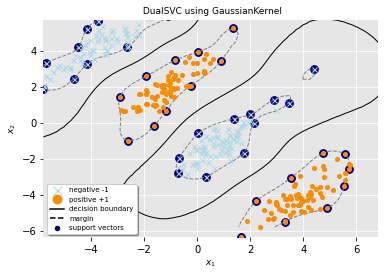

cvxopt svc accuracy score is 1.0
cvxopt svc found 41 support vectors from 300 examples
cvxopt svc b is 0.016232560006575712

CPU times: user 2.02 ms, sys: 0 ns, total: 2.02 ms
Wall time: 1.81 ms


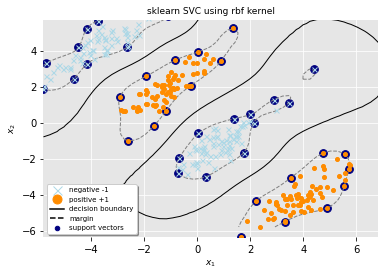

sklearn svc accuracy score is 1.0
sklearn svc found 41 support vectors from 300 examples
sklearn svc b is [0.01622188]


In [51]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), C=10, optimizer=SMOClassifier, verbose=2)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), C=10, optimizer='cvxopt', verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'cvxopt svc accuracy score is {svc.score(X_test, y_test)}')
print(f'cvxopt svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SklSVC(kernel='rbf', gamma='auto', C=1)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
print(f'sklearn svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

In [44]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-4.0150e+04	pcost:  1.1141e+05	gap:  1.3604e+00
 100	 100	-3.9385e+11	pcost:  1.0230e+05	gap:  3.8499e+06
 200	 200	-2.2843e+11	pcost:  9.5029e+04	gap:  2.4038e+06
 300	 300	-9.7116e+08	pcost:  9.5029e+04	gap:  1.0221e+04
 400	 400	-2.6701e+10	pcost:  9.5029e+04	gap:  2.8098e+05
 500	 500	-4.4005e+09	pcost:  9.5029e+04	gap:  4.6308e+04
 600	 600	-3.7306e+08	pcost:  9.5029e+04	gap:  3.9268e+03
 700	 700	-2.1022e+08	pcost:  9.5029e+04	gap:  2.2132e+03
 800	 800	-1.8784e+08	pcost:  9.5029e+04	gap:  1.9776e+03
 900	 900	-1.8258e+08	pcost:  9.5029e+04	gap:  1.9223e+03

CPU times: user 19 s, sys: 11 s, total: 30 s
Wall time: 3.98 s


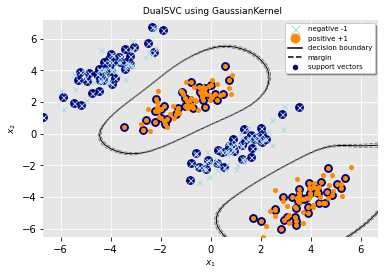

svc accuracy score is 1.0
svc found 139 support vectors from 300 examples
svc b is -7.29183438229803


In [34]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), C=10, optimizer=AdaGrad, fit_intercept=True, verbose=100)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

epoch	iter	 cost	
   0	   0	-2.4357e+05	pcost:  1.0318e+05	gap:  3.3605e+00
   1	   1	-2.9261e+13	pcost:  1.0182e+05	gap:  2.8736e+08
   2	   2	-3.3227e+13	pcost:  1.0182e+05	gap:  3.2631e+08
   3	   3	 7.0077e+13	pcost:  9.8014e+04	gap: -7.1497e+08

CPU times: user 963 ms, sys: 411 ms, total: 1.37 s
Wall time: 209 ms


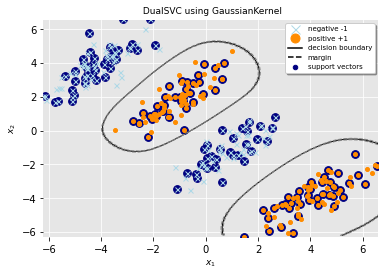

svc accuracy score is 1.0
svc found 145 support vectors from 300 examples
svc b is -13.825422419104967


In [59]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), C=10, optimizer=AdaGrad, fit_intercept=False, verbose=True)
%time svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
print(f'svc found {len(svc.support_)} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

#### Support Vector Regression

In [ ]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SklSVR
from sklearn.model_selection import train_test_split

iter	 cost
   0	-1.9380e+00
   5	-2.1595e+00
  10	-2.1678e+00
  15	-2.1770e+00
  20	-2.1815e+00
  25	-2.1845e+00
  30	-2.1848e+00
  35	-2.2273e+00
  40	-2.2347e+00
  45	-2.2382e+00
  50	-2.2427e+00
  55	-2.2449e+00

CPU times: user 1.21 s, sys: 1.23 s, total: 2.44 s
Wall time: 372 ms


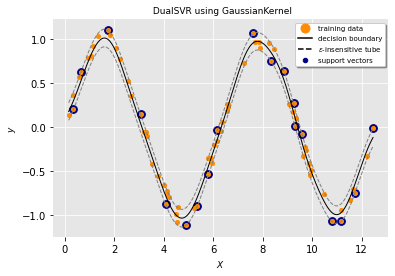

svr r2 score is 0.9818438800724006
svr found 19 support vectors from 75 examples
svr b is -0.00350379715477003

     pcost       dcost       gap    pres   dres
 0:  7.1674e+01 -1.6923e+03  2e+03  2e-15  1e-14
 1:  6.3454e+01 -8.6894e+01  2e+02  2e-14  1e-14
 2:  9.8863e+00 -1.3805e+01  2e+01  1e-14  1e-14
 3:  9.3548e-01 -5.0482e+00  6e+00  4e-15  4e-15
 4: -1.6500e+00 -2.9191e+00  1e+00  6e-15  2e-15
 5: -2.1287e+00 -2.3743e+00  2e-01  5e-15  2e-15
 6: -2.2302e+00 -2.2645e+00  3e-02  2e-15  2e-15
 7: -2.2436e+00 -2.2477e+00  4e-03  3e-15  2e-15
 8: -2.2454e+00 -2.2455e+00  7e-05  3e-16  2e-15
 9: -2.2454e+00 -2.2454e+00  7e-07  1e-15  2e-15
Optimal solution found.

CPU times: user 107 ms, sys: 104 ms, total: 211 ms
Wall time: 33.6 ms


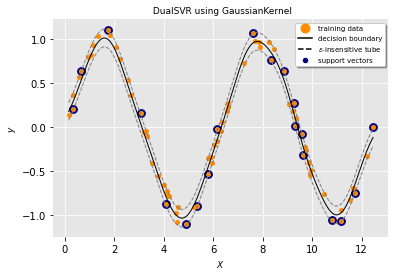

cvxopt svr r2 score is 0.9818956752270985
cvxopt svr found 20 support vectors from 75 examples
cvxopt svr b is -0.007759060829779911

CPU times: user 912 µs, sys: 431 µs, total: 1.34 ms
Wall time: 790 µs


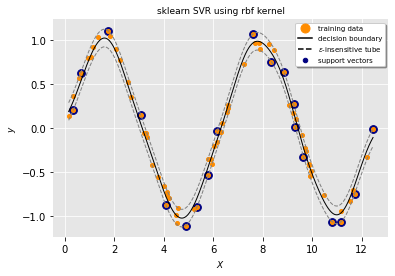

sklearn svr r2 score is 0.9820191972919681
sklearn svr found 19 support vectors from 75 examples
sklearn svr b is [0.00682271]


In [57]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, optimizer=SMORegression, verbose=5)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, optimizer='cvxopt', verbose=True)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'cvxopt svr r2 score is {svr.score(X_test, y_test)}')
print(f'cvxopt svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SklSVR(kernel='rbf', gamma='auto', C=1)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'sklearn svr r2 score is {svr.score(X_test, y_test)}')
print(f'sklearn svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')

In [25]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-2.7192e+00	pcost: -1.3468e+00	gap:  1.0191e+00	rnorm: 1.9735e-02
  10	  10	-2.2845e+00	pcost: -1.3943e+00	gap:  6.3852e-01	rnorm: 9.4530e-03
  20	  20	-2.3071e+00	pcost: -1.3979e+00	gap:  6.5040e-01	rnorm: 8.5906e-03
  30	  30	-2.2169e+00	pcost: -1.4108e+00	gap:  5.7138e-01	rnorm: 8.7938e-03
  40	  40	-2.2143e+00	pcost: -1.4108e+00	gap:  5.6954e-01	rnorm: 8.7730e-03
  50	  50	-2.2101e+00	pcost: -1.4108e+00	gap:  5.6651e-01	rnorm: 8.7549e-03
  60	  60	-2.1569e+00	pcost: -1.4108e+00	gap:  5.2886e-01	rnorm: 7.8354e-03
  70	  70	-2.0807e+00	pcost: -1.4108e+00	gap:  4.7482e-01	rnorm: 7.5678e-03
  80	  80	-2.0044e+00	pcost: -1.4108e+00	gap:  4.2072e-01	rnorm: 7.8965e-03
  90	  90	-1.9106e+00	pcost: -1.4108e+00	gap:  3.5428e-01	rnorm: 6.7051e-03
 100	 100	-1.8629e+00	pcost: -1.4108e+00	gap:  3.2041e-01	rnorm: 7.1079e-03
 110	 110	-1.8419e+00	pcost: -1.4108e+00	gap:  3.0556e-01	rnorm: 7.0191e-03
 120	 120	-1.8328e+00	pcost: -1.4108e+00	gap:  2.9909e-01	rnorm: 6.951

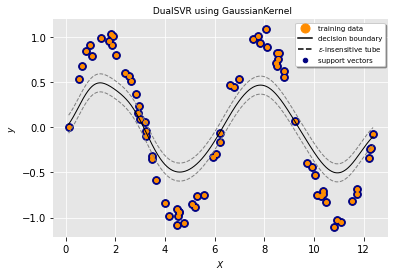

svr r2 score is 0.6103971158955385
svr found 75 support vectors from 75 examples
svr b is -0.0049374442127616425


In [28]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, 
              optimizer=AdaGrad, fit_intercept=True, verbose=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

epoch	iter	 cost	
   0	   0	-2.3759e+00	pcost: -1.4212e+00	gap:  6.7173e-01	rnorm: 1.4863e-01
  10	  10	-1.4951e+00	pcost: -1.4212e+00	gap:  5.2018e-02	rnorm: 2.1578e-01
  20	  20	-1.4647e+00	pcost: -1.4212e+00	gap:  3.0574e-02	rnorm: 2.2091e-01
  30	  30	-1.3938e+00	pcost: -1.4212e+00	gap: -1.9305e-02	rnorm: 1.9642e-01

CPU times: user 450 ms, sys: 535 ms, total: 985 ms
Wall time: 212 ms


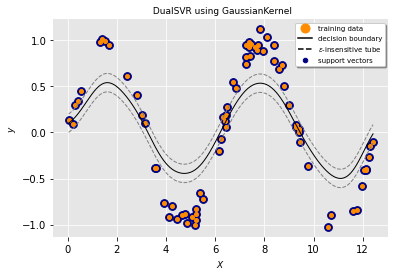

svr r2 score is 0.7226964793726702
svr found 75 support vectors from 75 examples
svr b is 0.03916819351724214


In [29]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), epsilon=0.1, C=10, 
              optimizer=AdaGrad, fit_intercept=False, verbose=10)
%time svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
print(f'svr r2 score is {svr.score(X_test, y_test)}')
print(f'svr found {len(svr.support_)} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')